In [1]:
#i'm just importing everything I could possibly need here
from scipy.signal import savgol_filter
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
from itertools import zip_longest
import matplotlib as mpl
import seaborn as sns
import pylab
import math
from operator import itemgetter
import re
# Import module to split dataset
from sklearn.model_selection import train_test_split
# Import module for fitting
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.svm import SVR
from sklearn import linear_model
import time
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler #https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MinMaxScaler.html#sklearn.preprocessing.MinMaxScaler
from sklearn.preprocessing import RobustScaler #https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.RobustScaler.html
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import RANSACRegressor
from sklearn.linear_model import TheilSenRegressor
from sklearn.linear_model import HuberRegressor
from sklearn.linear_model import SGDRegressor
from sklearn.svm import SVR
from sklearn.kernel_ridge import KernelRidge
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.linear_model import ElasticNet
from sklearn.isotonic import IsotonicRegression
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.cross_decomposition import PLSRegression
from sklearn.neural_network import MLPRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.gaussian_process.kernels import DotProduct, WhiteKernel
import seaborn as sns

In [2]:
#lets unpickle our dataframes!
only_347H = pd.read_pickle("./only_347H.pkl")
only_740H = pd.read_pickle("./only_740H.pkl")

#Maybe we could replace composition for 347H with dummy variables instead?
only_347H.replace([0.04, 0.08], ['Low Carbon', 'High Carbon'], inplace=True)
carbon = pd.get_dummies(only_347H['Composition'], drop_first=True)
only_347H = pd.concat([only_347H, carbon], axis=1)
only_347H.drop(['Composition'], axis=1, inplace=True)
#print (only_347H.head)

# Split data into 'X' features and 'y' target label sets
X = only_740H[['Strain', 'Temperature', 'Time', 'FZ',
                  'HAZ']]
y = only_740H['Average']
Z = only_347H[['Strain', 'Temperature', 'Time', 'FZ',
                  'HAZ', 'Low Carbon']]
i = only_347H['Average']

# Order is as follows:
1. We need to preprocess our data. 
    * Easiest way is to use Standard scaler to transform our data.
2. We need to choose our models
    * Decision Tree, Random Forest some examples, but overall we would like to just use a whole list of them
3. We need to use cross validation to refine our results
    * Included in this is to use kernal trick

In [3]:
#we created a list of all the models and created the param_grid for use in GridSearchCV

models = {'Kernal Ridge':KernelRidge(),                     #https://scikit-learn.org/stable/modules/generated/sklearn.kernel_ridge.KernelRidge.html
          'Decision Tree': DecisionTreeRegressor(),         #https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeRegressor.html
          'Random Forest': RandomForestRegressor(),         #https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestRegressor.html
          'K Neighbors': KNeighborsRegressor(),             #https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsRegressor.html
          'Elastic Net': ElasticNet(),                      #https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.ElasticNet.html#sklearn.linear_model.ElasticNet
          'RANSAC': RANSACRegressor(),                      #https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.RANSACRegressor.html#sklearn.linear_model.RANSACRegressor
          'Theil Sen': TheilSenRegressor(),                 #https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.TheilSenRegressor.html#sklearn.linear_model.TheilSenRegressor
          'Huber': HuberRegressor(),                        #https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.HuberRegressor.html#sklearn.linear_model.HuberRegressor
          'SGD': SGDRegressor(),                            #https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.SGDRegressor.html#sklearn.linear_model.SGDRegressor
          'Gradient Boosting': GradientBoostingRegressor(), #https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.GradientBoostingRegressor.html#sklearn.ensemble.GradientBoostingRegressor
          'Gaussian Process': GaussianProcessRegressor(), #results were all over the place #https://scikit-learn.org/stable/modules/generated/sklearn.gaussian_process.GaussianProcessRegressor.html#sklearn.gaussian_process.GaussianProcessRegressor
          'PLS' : PLSRegression(),                          #https://scikit-learn.org/stable/modules/generated/sklearn.cross_decomposition.PLSRegression.html#sklearn.cross_decomposition.PLSRegression
          'Multi-layer Perceptron': MLPRegressor(),         #https://sc3ikit-learn.org/stable/modules/generated/sklearn.neural_network.MLPRegressor.html#sklearn.neural_network.MLPRegressor
          'Support Vector':SVR()                            #https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVR.html
          #'Isotonic': IsotonicRegression(), #need to flatten X values, also only for all increasing or all decreasing #https://scikit-learn.org/stable/modules/generated/sklearn.isotonic.IsotonicRegression.html#sklearn.isotonic.IsotonicRegression
          #'Logistic': LogisticRegression() #doesn't work for continuous
         }

As you might imagine, the hyperparameter optimization would've taken me years to run, lets see how long it takes just to do one. We will be switching between the above hyperparameter with the full factorial and the below one with the single value.

In [12]:
C_range = np.logspace(-2, 10, 5) #np.logspace(-2, 10, 13)
gamma_range = [10e-5, 0.001, 0.01, 0.1, 1, 100]#np.logspace(-9, 3, 8) #np.logspace(-9, 3, 13)
alpha_range = np.logspace(-7, 2, 8)
epsilon_range = np.concatenate((np.logspace(-5, 0, 3),np.arange(2,11,2))) #np.logspace(-5, 0, 8)
epsilon_range_v2 = np.logspace(-9, 0, 4) #np.logspace(-9, 0, 13)
epsilon_range_v3 = np.linspace(1.01,20,5)
max_iter_range = np.arange(100, 900, 200, dtype=int)
n_estimator_range = np.arange(100, 400, 100, dtype=int)
learning_rate_range = np.linspace(0.02,0.5,5)
max_depth_range = np.linspace(3,10,4, dtype=int)

hyperparameters = {'Kernal Ridge':[{'kernel':  ['rbf'], #The best parameters are {'alpha': 6.210526315789474e-05, 'gamma': 0.05, 'kernel': 'rbf'} with a score of 0.81
                                    'alpha': np.linspace(0.00001, 0.0001, 10),                 
                                    'gamma': np.arange(0.005, 0.08, 8)}],               
                   'Decision Tree': [{'criterion': ['mse', 'mae'], #The best parameters are {'criterion': 'mse', 'max_depth': 13} with a score of 0.96
                                      'max_depth' : [13]}],
                   'Random Forest': [{'criterion': ['mse'], #The best parameters are {'criterion': 'mse', 'max_depth': 15.0, 'max_features': 'auto', 'min_samples_leaf': 4, 'min_samples_split': 10, 'n_estimators': 387} with a score of 0.96
                                      'n_estimators': np.linspace(50, 500, 8, dtype=int),
                                      'max_depth' : np.linspace(5, 50, 5), 
                                      'max_features': ['auto', 'sqrt'],
                                      'min_samples_leaf': [2, 4, 8, 20],
                                      'min_samples_split': [5, 10, 15, 20] }],
                   'K Neighbors': [{'n_neighbors': np.linspace(2,50,13,dtype=int), #The best parameters are {'n_neighbors': 14, 'weights': 'uniform'} with a score of 0.95
                                    'weights':['uniform', 'distance']}],
                   'Elastic Net': [{'alpha':alpha_range, 
                                    'max_iter':np.linspace(10,200 , 8, dtype=int), 
                                    'l1_ratio': np.arange(0.0, 1.0, 0.1)}],
                   'RANSAC': True, #don't know if there's any hyperparameter types to adjust  #0.0147 sec
                   'Theil Sen': [{'max_iter': max_iter_range}], #not a lot of hyperparameters to optimize #3.5645sec
                   'Huber': [{'epsilon': epsilon_range_v3,                        #0.101
                              'alpha':alpha_range, 
                              'max_iter': max_iter_range}],
                   'SGD': [{'alpha': alpha_range,                          #0.08835
                            'epsilon':epsilon_range_v2, #don't know if it's the same epsilon
                            'loss': ['squared_loss', 'huber', 'epsilon_insensitive'],
                            'penalty': ['l2', 'l1', 'elasticnet'],
                            'learning_rate': ['constant', 'optimal', 'invscaling']}],
                   'Gradient Boosting': [{'alpha': np.logspace(-7, 0, 7),
                                          'n_estimators': n_estimator_range,
                                          'learning_rate': learning_rate_range,
                                          'max_depth':max_depth_range,
                                          'min_samples_leaf':[3,5,9,17], 
                                          'max_features':[0.1,0.3,0.5,1]}],
                   'Gaussian Process' : [{'alpha': alpha_range, #'kernel': ['rbf'], #7.43
                                         'n_restarts_optimizer': np.linspace(1,7,3, dtype=int)}] , #results were all over the place
                   'PLS' : [{'n_components': np.linspace(2,10,6,dtype=int),
                            'max_iter': max_iter_range}],    #not too much we can do here
                   'Multi-layer Perceptron': [{'solver': ['lbfgs'],              #22.36
                                               'epsilon': epsilon_range,
                                               'max_iter': max_iter_range,
                                               'alpha': alpha_range}], #'hidden_layer_sizes':np.arange(10, 15)
                   'Support Vector': [{'kernel': ['rbf', 'linear','sigmoid'],
                                       'degree': np.arange(2,6,dtype=int),
                                       'gamma': gamma_range,
                                       'C': C_range
                                      }]
                   #'Isotonic': IsotonicRegression(), #need to flatten X values, also only for all increasing or all decreasing
                   #'Logistic': LogisticRegression() #doesn't work for continuous
                  }

C:\Users\DuchJ\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:645: DataConversionWarning: Data with input dtype uint8, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\DuchJ\Anaconda3\lib\site-packages\sklearn\base.py:464: DataConversionWarning: Data with input dtype uint8, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
C:\Users\DuchJ\Anaconda3\lib\site-packages\ipykernel_launcher.py:28: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Kernal Ridge
The best parameters are {'alpha': 1e-05, 'gamma': 0.005, 'kernel': 'rbf'} with a score of 0.72
Process Time  28.26959689999967
Decision Tree


C:\Users\DuchJ\Anaconda3\lib\site-packages\ipykernel_launcher.py:45: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
C:\Users\DuchJ\Anaconda3\lib\site-packages\ipykernel_launcher.py:28: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


The best parameters are {'criterion': 'mse', 'max_depth': 13} with a score of 0.96
Process Time  0.6560512000005474
Random Forest


C:\Users\DuchJ\Anaconda3\lib\site-packages\ipykernel_launcher.py:45: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
C:\Users\DuchJ\Anaconda3\lib\site-packages\ipykernel_launcher.py:28: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


The best parameters are {'criterion': 'mse', 'max_depth': 50.0, 'max_features': 'auto', 'min_samples_leaf': 4, 'min_samples_split': 15, 'n_estimators': 50} with a score of 0.96
Process Time  299.9322170000005
K Neighbors


C:\Users\DuchJ\Anaconda3\lib\site-packages\ipykernel_launcher.py:45: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
C:\Users\DuchJ\Anaconda3\lib\site-packages\ipykernel_launcher.py:28: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


The best parameters are {'n_neighbors': 18, 'weights': 'uniform'} with a score of 0.95
Process Time  1.6394921000000977
Elastic Net


C:\Users\DuchJ\Anaconda3\lib\site-packages\ipykernel_launcher.py:45: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
C:\Users\DuchJ\Anaconda3\lib\site-packages\ipykernel_launcher.py:28: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
C:\Users\DuchJ\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Users\DuchJ\Anaconda3\lib\site-packages\ipykernel_launcher.py:45: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
C:\Users\DuchJ\Anaconda3\lib\site-packages\ipykernel_la

The best parameters are {'alpha': 0.0007196856730011528, 'l1_ratio': 0.0, 'max_iter': 200} with a score of 0.60
Process Time  1.2872370999994018
RANSAC
740H RANSAC Model predicts: 0.49177035780461587
Process Time  0.053228300000228046
Theil Sen
The best parameters are {'max_iter': 500} with a score of -17.75
Process Time  6.506990800000494
Huber


C:\Users\DuchJ\Anaconda3\lib\site-packages\ipykernel_launcher.py:45: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
C:\Users\DuchJ\Anaconda3\lib\site-packages\ipykernel_launcher.py:28: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


The best parameters are {'alpha': 0.26826957952797276, 'epsilon': 15.2525, 'max_iter': 100} with a score of 0.60
Process Time  1.4028010000001814
SGD


C:\Users\DuchJ\Anaconda3\lib\site-packages\ipykernel_launcher.py:45: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
C:\Users\DuchJ\Anaconda3\lib\site-packages\ipykernel_launcher.py:28: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
C:\Users\DuchJ\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\Users\DuchJ\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:166: FutureWarning: max_iter and tol parameters have been added in SGDRegressor in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not

The best parameters are {'alpha': 1.9306977288832498e-06, 'epsilon': 1e-06, 'learning_rate': 'invscaling', 'loss': 'squared_loss', 'penalty': 'l2'} with a score of 0.60
Process Time  2.3741635999995196
Gradient Boosting


ValueError: alpha must be in (0.0, 1.0) but was 1.0

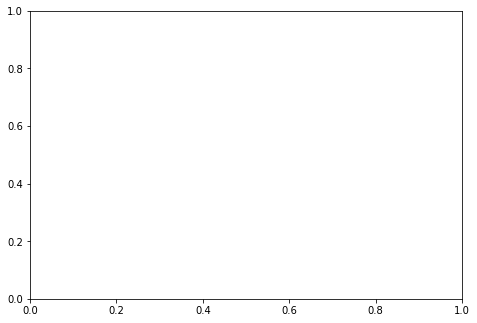

In [13]:
sns.set_palette('colorblind')

#Standard Scaler is most common example: https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html
preprocess = {'Standard': StandardScaler(), 'Min Max': MinMaxScaler(), 'Robust': RobustScaler()} #we'll get around to this later
material_selection = [('740H', X, y),('347H', Z, i)]
counting_plots = 1

for mat_name, inputs, outputs in material_selection:
    #it may be training the data on the index
    #inputs = pd.DataFrame.to_numpy(inputs)
    #outputs = pd.DataFrame.to_numpy(outputs)
    #we need standard scaler for the input and output data
    scaler = StandardScaler()
    input_data = scaler.fit_transform(inputs)
    
    input_train, input_test, output_train, output_test = train_test_split(input_data, outputs, test_size=0.3, random_state=100)
    #scaler = StandardScaler()
    #input_train = scaler.fit_transform(input_train)
    #input_test = scaler.fit_transform(input_test)
    fig = plt.figure(counting_plots)
    ax = fig.add_axes([0,0,1,1])
    title= "Modeled Hardness vs. Actual Hardness for {}".format(mat_name)
    
    if mat_name == '740H': features=5
    elif mat_name == '347H':features=6
    
    for key in models.keys():
        tic = time.clock()
        print (key)
        model = models[key]
        hyperparam_grid = hyperparameters[key]
        
        if hyperparam_grid == True:
            model.fit(input_train.reshape(-1, features), output_train)
            print('{} {} Model predicts: {}'.format(mat_name, key, model.score(input_test.reshape(-1, features), output_test)))
        else:
            #input_data_y = scaler.fit_transform(y)
            #cv = StratifiedShuffleSplit(n_splits=20, test_size=0.2, random_state=50) #ValueError: The least populated class in y has only 1 member, which is too few. The minimum number of groups for any class cannot be less than 2.
            cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=50)
            #cv = train_test_split(test_size=0.2, random_state=42)
            grid = GridSearchCV(model, param_grid=hyperparam_grid, cv=3, n_jobs=-1)
            grid.fit(input_train.reshape(-1, features), output_train) #this is typically done with the X and y not X_train and y_train
            print("The best parameters are %s with a score of %0.2f" % (grid.best_params_, grid.best_score_))
            
        toc = time.clock()
        print ('Process Time ', toc-tic)
        #model.fit(input_train.reshape(-1, features), output_train)
        #print('{} {} Model predicts: {}'.format(mat_name, key, model.score(input_test.reshape(-1, features), output_test)))
        
        '''
        predicted_test = model.predict(input_test.reshape(-1, features))
        
        fig.suptitle(title)
        ax.set_xlabel("Predicted Hardness")
        ax.set_ylabel("Actual Hardness")
        ax.scatter(predicted_test, output_test, label=key)
        plt.legend()
        #plt.show()
        #'''
        
    
    counting_plots+=1

So the best models are: Decision Tree, Random Forest, K Neighbors with scores of 0.96, 0.96, 0.95 respectively. I gotta say I'm blown away, the other model scores are around 0.6 or 0.72 but this one works super well!

Of course, we should be worried about overfitting. Fortunately, we only trained our model on the training data, so lets verify that we're not overfitting using our test data! I also threw in Kernel Ridge to see what a score of 0.81 looks like.

C:\Users\DuchJ\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:645: DataConversionWarning: Data with input dtype uint8, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\DuchJ\Anaconda3\lib\site-packages\sklearn\base.py:464: DataConversionWarning: Data with input dtype uint8, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)


Decision Tree Model for 740H predicts: 0.9585139501833103
Random Forest Model for 740H: 0.9584921075243134
K Neighbors Model for 740H: 0.951852088178883
Kernel Ridge Model for 740H: 0.8363920444772659


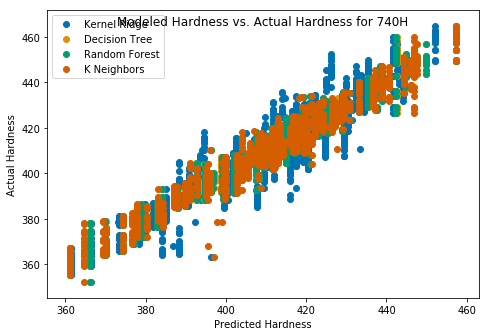

In [19]:
scaler = StandardScaler()
input_data = scaler.fit_transform(X)
input_train, input_test, output_train, output_test = train_test_split(input_data, y, test_size=0.2, random_state=100)

#'Decision Tree': The best parameters are {'criterion': 'mse', 'max_depth': 13} with a score of 0.96
#'Random Forest': #The best parameters are {'criterion': 'mse', 'max_depth': 15.0, 'max_features': 'auto', 'min_samples_leaf': 4, 'min_samples_split': 10, 'n_estimators': 387} with a score of 0.96
#'K Neighbors': #The best parameters are {'n_neighbors': 14, 'weights': 'uniform'} with a score of 0.95
#kernal ridge : The best parameters are {'alpha': 6.210526315789474e-05, 'gamma': 0.05, 'kernel': 'rbf'} with a score of 0.81

dt = DecisionTreeRegressor(criterion = 'mse', max_depth = 13)
rf = RandomForestRegressor(criterion = 'mse', max_depth = 15, max_features= 'auto', min_samples_leaf= 4, min_samples_split= 10, n_estimators= 387)
kn = KNeighborsRegressor(n_neighbors= 14, weights= 'uniform')
kr = KernelRidge(alpha= 6.210526315789474e-05, gamma= 0.05, kernel= 'rbf')

dt.fit(input_train.reshape(-1, features), output_train)
print('Decision Tree Model for 740H predicts: {}'.format(dt.score(input_test.reshape(-1, features), output_test)))
predicted_test_dt = dt.predict(input_test.reshape(-1, features))
rf.fit(input_train.reshape(-1, features), output_train)
print('Random Forest Model for 740H: {}'.format(rf.score(input_test.reshape(-1, features), output_test)))
predicted_test_rf = rf.predict(input_test.reshape(-1, features))
kn.fit(input_train.reshape(-1, features), output_train)
print('K Neighbors Model for 740H: {}'.format(kn.score(input_test.reshape(-1, features), output_test)))
predicted_test_kn = kn.predict(input_test.reshape(-1, features))
kr.fit(input_train.reshape(-1, features), output_train)
print('Kernel Ridge Model for 740H: {}'.format(kr.score(input_test.reshape(-1, features), output_test)))
predicted_test_kr = kr.predict(input_test.reshape(-1, features))

fig = plt.figure(counting_plots)
ax = fig.add_axes([0,0,1,1])
    
fig.suptitle(title)
ax.set_xlabel("Predicted Hardness")
ax.set_ylabel("Actual Hardness")
ax.scatter(predicted_test_kr, output_test, label='Kernel Ridge')
ax.scatter(predicted_test_dt, output_test, label='Decision Tree')
ax.scatter(predicted_test_rf, output_test, label='Random Forest')
ax.scatter(predicted_test_kn, output_test, label='K Neighbors')
plt.legend()

# It works

# Junk and Testing Code

In [ ]:
import numpy as np
print ()

In [ ]:
'''
C_range = np.logspace(-2, 10, 5) #np.logspace(-2, 10, 13)
gamma_range = np.logspace(-9, 3, 4) #np.logspace(-9, 3, 13)
alpha_range = np.logspace(-9, 3, 4)
epsilon_range = np.concatenate((np.logspace(-5, 0, 3),np.arange(2,11,2))) #np.logspace(-5, 0, 8)
epsilon_range_v2 = np.logspace(-9, 0, 4) #np.logspace(-9, 0, 13)
epsilon_range_v3 = np.linspace(1.01,20,5)
max_iter_range = np.arange(100, 900, 200, dtype=int)
n_estimator_range = np.arange(100, 400, 100, dtype=int)
learning_rate_range = np.linspace(0.02,0.5,5)
max_depth_range = np.linspace(3,10,4, dtype=int)

#each of these models will call a different param_grid because some of them use different hyperparameters

hyperparameters = {'Kernal Ridge':[{'kernel':  ['rbf'],#['rbf', 'poly', 'linear'], #49.8 sec to run just one value
                                    'alpha': [10**-5], #alpha_range, 
                                    'gamma': [10**-5]}], #gamma_range}],
                   #[{'kernel': ['rbf', 'poly'],'alpha': alpha_range,'gamma': gamma_range}, {'kernel': ['linear'],'alpha': alpha_range}],        #we're splitting this into two dictionaries because      #gamma doesn't work for a linear kernel  
                   'Decision Tree': [{'criterion': ['mse', 'friedman_mse', 'mae'], #16.07 sec to run full hyperparameter
                                      'max_depth' : np.arange(3, 15)}],
                   'Random Forest': [{'criterion': ['mse', 'mae'], 
                                      'n_estimators': np.linspace(start = 200, stop = 2000, num = 10, dtype=int),
                                      'max_depth' : np.arange(3, 15), 
                                      'max_features': ['auto', 'sqrt'],
                                      'min_samples_leaf': [1, 2, 4],
                                      'min_samples_split': [2, 5, 10] }],
                   'K Neighbors': [{'n_neighbors': np.arange(2,15,dtype=int), 
                                    'weights':['uniform', 'distance']}],
                   'Elastic Net': [{'alpha':alpha_range, 
                                    'max_iter':np.arange(1, 14, 3, dtype=int), 
                                    'l1_ratio': np.arange(0.0, 1.0, 0.1)}],
                   'RANSAC': True, #don't know if there's any hyperparameter types to adjust
                   'Theil Sen': [{'max_iter': max_iter_range}], #not a lot of hyperparameters to optimize
                   'Huber': [{'epsilon': epsilon_range_v3, 
                              'alpha':alpha_range, 
                              'max_iter': max_iter_range}],
                   'SGD': [{'alpha': alpha_range, 
                            'epsilon':epsilon_range, #don't know if it's the same epsilon
                            'loss': ['squared_loss', 'huber', 'epsilon_insensitive'],
                            'penalty': ['l2', 'l1', 'elasticnet'],
                            'learning_rate': ['constant', 'optimal', 'invscaling']}],
                   'Gradient Boosting': [{'alpha': alpha_range,
                                          'n_estimators': n_estimator_range,
                                          'learning_rate': learning_rate_range,
                                          'max_depth':max_depth_range,
                                          'min_samples_leaf':[3,5,9,17], 
                                          'max_features':[0.1,0.3,0.5,1]}],
                   'Gaussian Process' : [{'kernel': ['rbf', 'poly','linear'],
                                         'alpha': alpha_range,
                                         'n_restarts_optimizer': np.linspace(1,10,5, dtype=int)}] , #results were all over the place
                   'PLS' : [{'n_components': np.linspace(2,10,6,dtype=int),
                            'max_iter': max_iter_range}],    #not too much we can do here
                   'Multi-layer Perceptron': [{'solver': ['lbfgs'], 
                                               'epsilon': epsilon_range_v2,
                                               'max_iter': np.linspace(500, 2000, 12, dtype=int),
                                               'alpha': np.logspace(-9, 0, 10),
                                               'solver': ['lbfgs', 'sgd', 'adam'] }], #'hidden_layer_sizes':np.arange(10, 15)
                   'Support Vector': [{'kernel': ['rbf', 'poly','linear','sigmoid'],
                                       'degree': np.arange(2,6,dtype=int),
                                       'gamma': gamma_range,
                                       'C': C_range
                                      }]
                   #'Isotonic': IsotonicRegression(), #need to flatten X values, also only for all increasing or all decreasing
                   #'Logistic': LogisticRegression() #doesn't work for continuous
                  }
                  #'''

In [ ]:
'''
%%time
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.model_selection import GridSearchCV
from matplotlib.colors import Normalize

class MidpointNormalize(Normalize):

    def __init__(self, vmin=None, vmax=None, midpoint=None, clip=False):
        self.midpoint = midpoint
        Normalize.__init__(self, vmin, vmax, clip)

    def __call__(self, value, clip=None):
        x, y = [self.vmin, self.midpoint, self.vmax], [0, 0.5, 1]
        return np.ma.masked_array(np.interp(value, x, y))

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=50)
    
model = linear_model.LinearRegression()
#C and gamma are only for classifiers, hyperparameters for linear regression are found here: https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html#sklearn.linear_model.LinearRegression
#C_range = np.logspace(-2, 10, 13)
#gamma_range = np.logspace(-9, 3, 13)
fit_intercept_range = np.array([True, False])
normalize_range = np.array([True, False])
param_grid = dict(fit_intercept=fit_intercept_range, normalize=normalize_range)
cv = StratifiedShuffleSplit(n_splits=20, test_size=0.2, random_state=50)
#cv = train_test_split(test_size=0.2, random_state=42)
grid = GridSearchCV(model, param_grid=param_grid, cv=cv, n_jobs=-1)
grid.fit(X, y)
print("The best parameters are %s with a score of %0.2f"
      % (grid.best_params_, grid.best_score_))
      '''